## Многомерная линейная регрессия. Метод главных компонент

**Библиотеки**

In [3]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_regression

from sklearn.decomposition import PCA

from mlxtend.plotting import plot_decision_regions

from torchvision import datasets
from torchvision import transforms

**1. Многомерная линейная регрессия**

**простое решение на основе МНК**

Тривиально получается, что решение задачи
<center>$
\begin{equation}
    \|
        \mathbf{XW} - \mathbf{Y}
    \|_2^2\to
    \min_\mathbf{W}
\end{equation}
$</center>

является матрица:
<center>$
\begin{equation}
    \mathbf{W}^*=\left(
       \mathbf{X}^T\mathbf{X}
    \right)^{-1}\mathbf{X}^T\mathbf{Y}
\end{equation}
$</center>

**Выборка без шума**

In [7]:
np.random.seed(0)
n = 2
l = 100
K = 2
beta = 0.

X = np.random.randn(l, n)
W_true = np.random.randn(n, K)

y = X@W_true + beta*np.random.randn(l, K)

In [10]:
W = np.linalg.inv(X.T@X)@X.T@y

((W - W_true)**2).mean()  # Имеется в виду норма Фробениуса, но просто для
                          # удобства взято среднее

5.854827030937197e-32

**Выборка с шумом**

In [12]:
np.random.seed(0)
betas = np.linspace(0, 10, 1000)
list_of_errors = []

for beta in betas:
    y = X@W_true + beta*np.random.randn(l, K)
    
    W = np.linalg.inv(X.T@X)@X.T@y
    
    list_of_errors.append(((W - W_true)**2).mean())

Зависимость расстояния между истинной матрицей параметров и аппроксимацией от $\beta$:

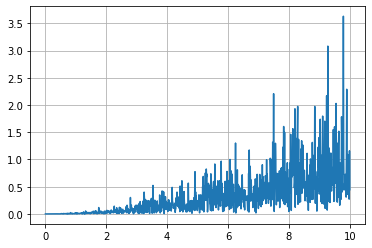

In [13]:
plt.plot(betas, list_of_errors)

plt.grid()
plt.show()

**2. SVD**

SVD-разложение:
<center>$
\begin{equation}
    \mathbf{X}=\mathbf{VDU}^T
\end{equation}
$</center>

Лемма (представление псевдообратной матрицы):
<center>$
\begin{equation}
    \mathbf{X}^+ =
    \left(
        \mathbf{X}^T\mathbf{X}
    \right)^T\mathbf{X}^T =
    \mathbf{UD}^{-1}\mathbf{V}^T
\end{equation}
$</center>

Получаем:
<center>$
\begin{equation}
    \mathbf{W}^*=\mathbf{UD}^{-1}\mathbf{V}^T\mathbf{Y}
\end{equation}
$</center>

In [15]:
np.random.seed(0)
n = 2
l = 100
K = 2
beta = 0.

X = np.random.randn(l, n)
W_true = np.random.randn(n, K)

y = X@W_true + beta*np.random.randn(l, K)

In [16]:
V, d, U = np.linalg.svd(X, full_matrices=False)  # SVD-разложение в NumPy
# full_matrices=False - срезанная матрица;
# если full_matrices=True, то матрица собств. вект. V будет иметь размерность
# (n x n). Но так как матрица X прямоугольная, то часть собств. вект. будет
# лишней, их full_matrices=False и отбрасывает.

# d - массив диагональных элементов, а не диагональная матрица.
# d - массив из корней собственных значений

D = np.eye(len(d))*d
lambd = d**2

Число обусловленности для матрицы $\mathbf{XX}^T$:

In [17]:
np.max(lambd) / np.min(lambd)

1.049588919547096

Качество аппроксимации:

In [18]:
W = (U.T@np.linalg.inv(D)@V.T)@y

((W - W_true)**2).mean()

5.72001193483009e-32

Посмотрим на результаты изменения $\mu$

In [22]:
np.random.seed(0)
mus = np.linspace(0, 1, 10)
list_of_errors = []

for mu in mus:
    lambd_new = np.array(lambd)
    lambd_new[1] = mu * lambd_new[0]
    d_new = np.sqrt(lambd_new)
    D_new = np.eye(len(d_new))*d_new
    X_new = V@D_new@U
    
    y = X_new@W_true
    
    W = np.linalg.inv(X_new.T@X_new)@X_new.T@y
    
    list_of_errors.append(((W - W_true)**2).mean())

Зависимость качества от $\mu$:

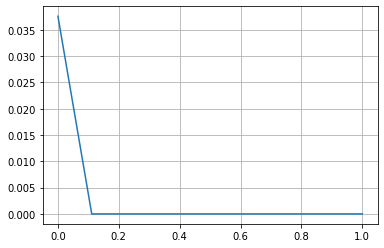

In [23]:
plt.plot(mus, list_of_errors)

plt.grid()
plt.show()

Картинка не самая информативная ввиду маленького количества точек.

Обобщим данный график:

In [24]:
np.random.seed(0)
mus = np.linspace(0., 1., 100)
betas = np.linspace(0., 2., 100)
list_of_errors = dict()

for beta in betas:
    list_of_errors[str(beta)] = dict()
    for mu in mus:
        lambd_new = np.array(lambd)
        lambd_new[1] = mu * lambd_new[0]
        d_new = np.sqrt(lambd_new)
        D_new = np.eye(len(d_new))*d_new
        X_new = V@D_new@U
    
        y = X_new@W_true + beta*np.random.randn(l, K)

        W = np.linalg.inv(X_new.T@X_new)@X_new.T@y

        list_of_errors[str(beta)][str(mu)] = ((W - W_true)**2).mean()

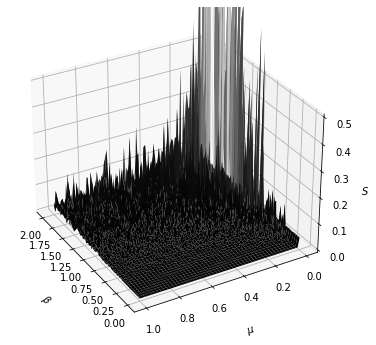

In [26]:
BETAS, MUS = np.meshgrid(betas, mus)
scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = list_of_errors[str(BETAS[i][j])][str(MUS[i][j])]
        
fig = plt.figure(figsize=(14.0, 6.0))
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, MUS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad=14), ax.set_ylabel(r'$\mu$', labelpad=14)
ax.set_zlabel(r'$S$'), ax.set_zlim((0, 0.5)), ax.view_init(30, 150)

plt.show()

Посмотрим, как влияют $\mu$ и $\beta$ на качество аппроксимации вектора $\mathbf{Y}$:

In [27]:
np.random.seed(0)
mus = np.linspace(0., 1., 100)
betas = np.linspace(0., 2., 100)
list_of_errors = dict()

for beta in betas:
    list_of_errors[str(beta)] = dict()
    for mu in mus:
        lambd_new = np.array(lambd)
        lambd_new[1] = mu * lambd_new[0]
        d_new = np.sqrt(lambd_new)
        D_new = np.eye(len(d_new))*d_new
        X_new = V@D_new@U
    
        y = X_new@W_true + beta*np.random.randn(l, K)

        W = np.linalg.inv(X_new.T@X_new)@X_new.T@y

        list_of_errors[str(beta)][str(mu)] = ((y - X_new@W)**2).mean()

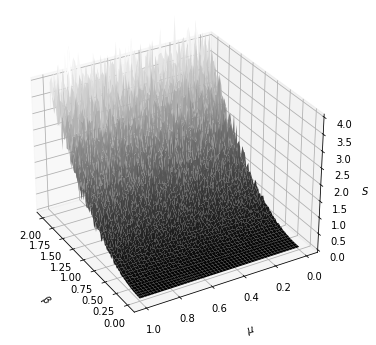

In [30]:
BETAS, MUS = np.meshgrid(betas, mus)
scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = list_of_errors[str(BETAS[i][j])][str(MUS[i][j])]
        
fig = plt.figure(figsize=(14.0, 6.0))
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, MUS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad=14), ax.set_ylabel(r'$\mu$', labelpad=14)
ax.set_zlabel(r'$S$'), ax.set_zlim((0, 4)), ax.view_init(30, 150)

plt.show()

Таким образом, от $\mu$ ничего не зависит.

**3. Регуляризация в многомерной регрессии**